In [ ]:
import os
from PIL import Image

BASE_DIR = "Tomato Datset"
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

print("Checking for corrupt or incompatible images...")
for root, dirs, files in os.walk(BASE_DIR):
    for file in files:
        if file.lower().endswith(valid_extensions):
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify() # Verify it's a valid image


                # Re-open to check if it can actually be converted to RGB
                with Image.open(file_path) as img:
                    img.convert("RGB")
            except Exception as e:
                print(f"❌ Removing corrupt file: {file_path} - Error: {e}")
                os.remove(file_path)

print("Cleanup complete. Try running the training again.")

Checking for corrupt or incompatible images...
Cleanup complete. Try running the training again.


In [62]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
import numpy as np
import cv2
import os

# 1. SETUP PATHS
BASE_DIR = "Tomato Datset"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# 2. THE UNBREAKABLE DATA GENERATOR
# This bypasses the TensorFlow 'decode_image' node that is causing your crash
class TomatoDataGenerator(Sequence):
    def __init__(self, directory, batch_size=16, img_size=(224, 224), subset="training"):
        self.directory = directory
        self.batch_size = batch_size
        self.img_size = img_size
        self.class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
        self.data = []

        # Collect all image paths and their labels (0, 1, 2)
        for i, class_name in enumerate(self.class_names):
            class_path = os.path.join(directory, class_name)
            for img_name in os.listdir(class_path):
                self.data.append((os.path.join(class_path, img_name), i))

        # Shuffle and Split (80% Train, 20% Val)
        np.random.seed(123)
        np.random.shuffle(self.data)
        split_idx = int(len(self.data) * 0.8)
        self.data = self.data[:split_idx] if subset == "training" else self.data[split_idx:]

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        labels = []
        for path, label in batch_data:
            # MANUALLY FORCE CONVERSION TO RGB
            img = cv2.imread(path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Fixes the Channel Error
                img = cv2.resize(img, self.img_size)
                images.append(img / 255.0) # Normalization
                labels.append(label)
        return np.array(images), np.array(labels)

# 3. INITIALIZE LOADERS
train_gen = TomatoDataGenerator(BASE_DIR, subset="training")
val_gen = TomatoDataGenerator(BASE_DIR, subset="validation")

print(f"✅ Generator ready. Training on {len(train_gen.data)} images.")

# 4. BUILD MODEL
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3), # Helps prevent overfitting
    layers.Dense(3, activation='softmax') # Outputs: Fresh, Rotten, Unripe
])

# 5. COMPILE & TRAIN
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Starting training with forced RGB conversion...")
model.fit(train_gen, validation_data=val_gen, epochs=10)

# 6. SAVE
model.save('tomato_freshness_model.keras') # Modern Keras format
print("✅ Project Saved: tomato_freshness_model.keras")

✅ Generator ready. Training on 257 images.
Starting training with forced RGB conversion...


C:\Users\Nishan Bhandari\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 974ms/step - accuracy: 0.3867 - loss: 7.4775 - val_accuracy: 0.6923 - val_loss: 0.7865
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 760ms/step - accuracy: 0.7109 - loss: 0.6656 - val_accuracy: 0.7846 - val_loss: 0.5954
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 749ms/step - accuracy: 0.8281 - loss: 0.4338 - val_accuracy: 0.5846 - val_loss: 1.3721
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 789ms/step - accuracy: 0.7852 - loss: 0.5598 - val_accuracy: 0.8000 - val_loss: 0.5359
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8320 - loss: 0.3469 - val_accuracy: 0.8308 - val_loss: 0.5157
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.9062 - loss: 0.2319 - val_accuracy: 0.8462 - val_loss: 0.5080
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 964ms/step - accuracy: 0.9414 - loss: 0.1846 - val_accuracy: 0.8154 - val_loss: 0.7121
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 923ms/step - accuracy: 0.9258 - loss: 0.2288 - val_accuracy: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


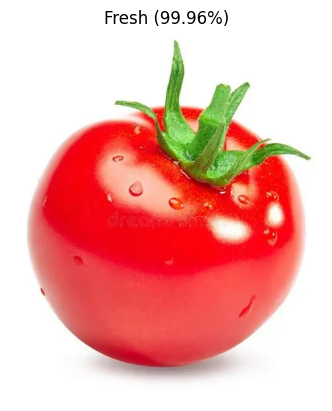

In [63]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. LOAD THE TRAINED MODEL
model = tf.keras.models.load_model('tomato_freshness_model.keras')

# 2. DEFINE CLASSES (Must match your folder names exactly)
class_names = ['Fresh', 'Rotten', 'Unripe']

def predict_tomato_freshness(image_path):
    # Load and force RGB conversion (matching our 'Unbreakable' pipeline)
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not find or open the image.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocessing
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_normalized = img_resized / 255.0
    img_final = np.expand_dims(img_normalized, axis=0) # Add batch dimension

    # Prediction
    predictions = model.predict(img_final)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    # Display Result
    plt.imshow(img_rgb)
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# 3. TEST ON YOUR CUSTOM IMAGE
# Replace 'test_tomato.jpg' with the path to your photo
predict_tomato_freshness('test_img.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


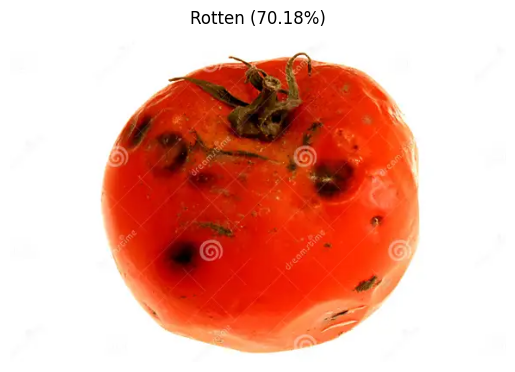

In [64]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. LOAD THE TRAINED MODEL
model = tf.keras.models.load_model('tomato_freshness_model.keras')

# 2. DEFINE CLASSES (Must match your folder names exactly)
class_names = ['Fresh', 'Rotten', 'Unripe']

def predict_tomato_freshness(image_path):
    # Load and force RGB conversion (matching our 'Unbreakable' pipeline)
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not find or open the image.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocessing
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_normalized = img_resized / 255.0
    img_final = np.expand_dims(img_normalized, axis=0) # Add batch dimension

    # Prediction
    predictions = model.predict(img_final)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    # Display Result
    plt.imshow(img_rgb)
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# 3. TEST ON YOUR CUSTOM IMAGE
# Replace 'test_tomato.jpg' with the path to your photo
predict_tomato_freshness('test_img1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step


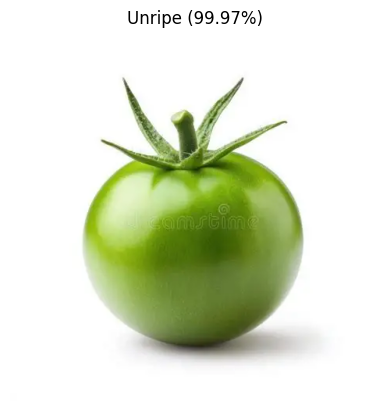

In [65]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. LOAD THE TRAINED MODEL
model = tf.keras.models.load_model('tomato_freshness_model.keras')

# 2. DEFINE CLASSES (Must match your folder names exactly)
class_names = ['Fresh', 'Rotten', 'Unripe']

def predict_tomato_freshness(image_path):
    # Load and force RGB conversion (matching our 'Unbreakable' pipeline)
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not find or open the image.")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocessing
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_normalized = img_resized / 255.0
    img_final = np.expand_dims(img_normalized, axis=0) # Add batch dimension

    # Prediction
    predictions = model.predict(img_final)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    # Display Result
    plt.imshow(img_rgb)
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# 3. TEST ON YOUR CUSTOM IMAGE
# Replace 'test_tomato.jpg' with the path to your photo
predict_tomato_freshness('test_img2.jpg')